# Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no.

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "label": false,
      "idx": 123,
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.


## Detailed Task Description

In the task you should perform all the model training on `train.jsonl` data and evaluate your models on `val.jsonl`. Note that you do not need `test.jsonl`.

Use **accuracy metric** for scoring.

The solution of either BoolQ or DaNetQA should include:


### [10%] 1. Data analysis


* 1.1  (10%) Download the data and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary.


### [40%] 2. Pretrained embeddings as features for classifier
* 2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.

**Note:** you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

* 2.2  (15%) Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

* 2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data.

**Note:** you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use `bert-base-multilingual-cased` (https://huggingface.co/bert-base-multilingual-cased).

* 2.4  (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).


### [40%] 3. Fine-tune BERT

* 3.1 (10%) Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

* 3.2   (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

* 3.3   (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1.

**Note:** you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

* 3.4   (10%)  Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).



### [10%] 4. Summary & results analysis


* 4.1    (5%) Compare the results of all the tested models and try to interpret them.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).


### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Provide links to the tutorials you use for reference.


# **1. Data analysis**

1.1. Importing modules, downloading the data and calculating basic statistics.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [ ]:
#load JSON file into pandas DataFrame for both datasets

train = pd.read_json('train.jsonl', lines=True)
val = pd.read_json('val.jsonl', lines=True)

In [ ]:
# explore the train dataset
train.head()

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,True
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,False


The train dataset consists of 9427 questions, the validation dataset - of 3270 questions.

In [ ]:
print ('Amount of questions in the train dataset:', len(train))
print ('Amount of questions in the validation dataset:', len(val))

Amount of questions in the train dataset: 9427
Amount of questions in the validation dataset: 3270


As we can see, the data is pretty balanced, “Yes” answers are slightly more common.

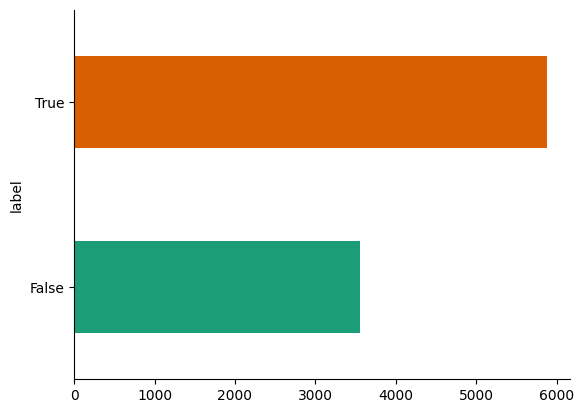

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
train.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We will tokenize the sentences:

In [ ]:
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return tokens
    #' '.join(tokens)

train['tokenized_question'] = train['question'].apply(preprocess)
val['tokenized_question'] = val['question'].apply(preprocess)
train['tokenized_passage'] = train['passage'].apply(preprocess)
val['tokenized_passage'] = val['passage'].apply(preprocess)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train['question_length'] = train['tokenized_question'].apply(lambda x: len(x))
val['question_length'] = val['tokenized_question'].apply(lambda x: len(x))
train['passage_length'] = train['tokenized_passage'].apply(lambda x: len(x))
val['passage_length'] = val['tokenized_passage'].apply(lambda x: len(x))

print ('Mean question length in the train dataset:', int(train['question_length'].mean().round()))
print ('Mean question length in the validation dataset:', int(val['question_length'].mean().round()))
print ('Mean passage length in the train dataset:', int(train['passage_length'].mean().round()))
print ('Mean passage length in the validation dataset:', int(val['passage_length'].mean().round()))

Mean question length in the train dataset: 5
Mean question length in the validation dataset: 5
Mean passage length in the train dataset: 58
Mean passage length in the validation dataset: 58


Now we can find the total amount of unique words and the most friquent word in questions of both datasets.

In [ ]:
def all_words(data):
  all_words = []
  for words in data:
    all_words+=words
  return all_words

question_words_train = all_words(train['tokenized_question'])
question_words_val = all_words(val['tokenized_question'])
passage_words_train = all_words(train['tokenized_passage'])
passage_words_val = all_words(val['tokenized_passage'])

print ('Total amount of words in the questions in the train dataset:', len(set(question_words_train)))
print ('Total amount of words in the passages the train dataset:', len(set(passage_words_train)))

Total amount of words in the questions in the train dataset: 9025
Total amount of words in the passages the train dataset: 48873


In [ ]:
question_count_train = {k: v for k, v in sorted(dict(Counter(question_words_train)).items(), key=lambda item: item[1], reverse = True)}
passage_count_train = {k: v for k, v in sorted(dict(Counter(passage_words_train)).items(), key=lambda item: item[1], reverse = True)}
print ('The most frequent word in the questions in the train dataset:', list(question_count_train.keys())[0])
print ('The most frequent word in the passages in the train dataset:', list(passage_count_train.keys())[0])

The most frequent word in the questions in the train dataset: season
The most frequent word in the passages in the train dataset: states


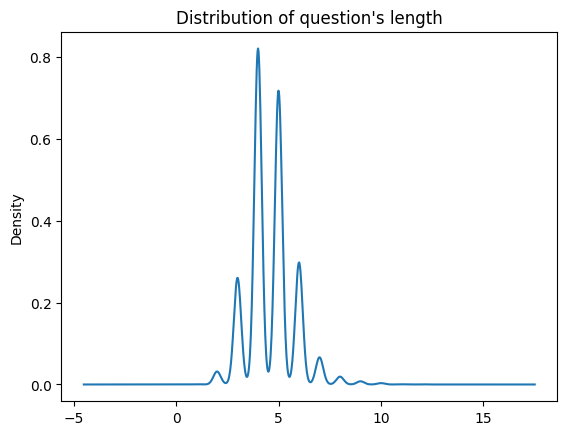

In [ ]:
train['question_length'].plot(kind='kde')
plt.title("Distribution of question's length")
plt.show()

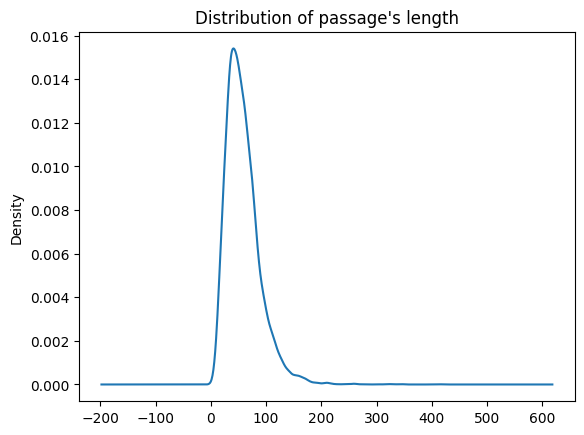

In [ ]:
train['passage_length'].plot(kind='kde')
plt.title("Distribution of passage's length")
plt.show()

#**2. Pretrained embeddings as features for classifier**

2.1 We will take pre-trained word2vec (GoogleNews vectors) embeddings and vectorize questions and passages using them.

In [ ]:
import gdown
url = "https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW"
destination = "GoogleNews-vectors-negative300.bin.gz"
gdown.download(url, destination)

Downloading...
From (original): https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW
From (redirected): https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW&confirm=t&uuid=08e7db39-5592-4620-ac20-fdede7f4443b
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:28<00:00, 57.0MB/s]


'GoogleNews-vectors-negative300.bin.gz'

In [ ]:
 from gensim.models import KeyedVectors
 from gensim.test.utils import datapath

In [ ]:
# loading a model
w2v_model = KeyedVectors.load_word2vec_format(datapath("/content/GoogleNews-vectors-negative300.bin.gz"), binary=True)

In [ ]:
import numpy as np

def vectorize(sentence):
    words_vecs = [w2v_model[word] for word in sentence if word in w2v_model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
#get arrays with all features from questions' and passages' embeddings

X_train = np.hstack([np.array([vectorize(sentence) for sentence in train.tokenized_question]),
                              np.array([vectorize(sentence) for sentence in train.tokenized_passage])])
X_val = np.hstack([np.array([vectorize(sentence) for sentence in val.tokenized_question]),
                              np.array([vectorize(sentence) for sentence in val.tokenized_passage])])

In [ ]:
X_train.shape

(9427, 600)

In [ ]:
y_train = train.label
y_val = val.label

2.2 We will use pretrained embeddings as features to a classifier in order to train classification model - SVM:

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.6464831804281346

As we can see, with SVM model correct answer to the question is given in 65% cases. That means that model makes mistakes 2 times less often then correct predictions, which is pretty good result, but not reliable enough.

2.3 Instead of word2vec embeddings we will get BERT embeddings from the questions and passages in train dataset and vectorize data.

We will use bert-base-multilingual-cased model from hugging face library (https://huggingface.co/bert-base-multilingual-cased).

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

The questions and passages will be tokenized:

In [ ]:
tokenized_question_train = train.question.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_passage_train = train.passage.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

tokenized_question_val = val.question.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_passage_val = val.passage.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (960 > 512). Running this sequence through the model will result in indexing errors


After tokenization, tokenized is a list of sentences. Each sentences is represented as a list of tokens. Then we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
def padded (sentences, max_len = 0):
  for i in sentences.values:
    if len(i) > max_len:
      max_len = len(i)
  padded = np.array([i + [0]*(max_len-len(i)) for i in sentences.values])
  return padded, max_len

Checking maximum length of tokenized questions and passages in train and validation dataset:

In [ ]:
padded(tokenized_passage_train)[1]

960

In [ ]:
padded(tokenized_passage_val)[1]

1073

In [ ]:
padded(tokenized_question_train)[1]

27

In [ ]:
padded(tokenized_question_val)[1]

24

In [ ]:
max_len_p = padded(tokenized_passage_val)[1]
max_len_q = padded(tokenized_question_train)[1]

In [ ]:
# getting arrays of vectorized data

X_train_1 = np.hstack([padded(tokenized_question_train, max_len_q)[0], padded(tokenized_passage_train, max_len_p)[0]])
X_val_1 = np.hstack([padded(tokenized_question_val, max_len_q)[0], padded(tokenized_passage_val, max_len_p)[0]])

2.4 Now we will train SVM model using BERT embeddings as features for a classifier.

In [ ]:
clf_1 = svm.SVC()
clf_1.fit(X_train_1, y_train)

SVC()

In [ ]:
y_pred_1 = clf_1.predict(X_val_1)
accuracy_1 = accuracy_score(y_val, y_pred_1)
accuracy_1

0.6330275229357798

SVM model trained on BERT embeddings gives correct answer to the question in given in 63% of cases. This result is close to the result of wor2vec embeddings and also not high enough.

# **3. Fine-tune BERT**

3.1 We will plit the data from train.jsonl into train and dev (dev_size = 10%), tokenize and format the data.

In [ ]:
train = pd.read_json('train.jsonl', lines=True)
val = pd.read_json('val.jsonl', lines=True)

First, we define an auxiliary function to handle the tokenization process. Indeed, encode will take care of the following steps:

- Divide the questions and excerpts into tokens
- Add a sentence start marker <s> and a marker </s> indicating the separation between the question and the passage, as well as the end of the input.
- Match tokens with their IDs.
- Fill in (with a <pad> marker) or truncate each pair of questions/excerpts to max_seq_length.
- Create attention masks to distinguish the corresponding markers from the fill markers.

We will use max_length = 256, because it is the biggest possible option for available amount of CUDA memory, the maximum standard input capacity for models like BERT is 512.

In [ ]:
import logging
logging.disable(logging.WARNING)

In [ ]:
import torch

def encode (tokenizer,questions, passages):
  input_ids = []
  attention_masks = []

  for question, passage in zip(questions, passages):
    encoded_dict = tokenizer.encode_plus(
          question, passage,                      # Sentences to encode.
          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
          max_length = 256,           # Pad & truncate all sentences.
          pad_to_max_length = True,
          return_attention_mask = True,   # Construct attn. masks.
          return_tensors = 'pt')    # Return pytorch tensors.

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)


In [ ]:
passages = train.passage.values
questions = train.question.values
answers = train.label.values.astype(int)

In [ ]:
input_ids, attention_masks = encode(tokenizer, questions, passages)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
labels = torch.tensor(answers)

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,484 training samples
  943 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

3.2 Initializing the model, optimizer and learning rate scheduler.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# We will run this model on the GPU.

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

For the purposes of fine-tuning, the authors of the BERT paper recommend choosing from the following values:
Batch size: 16, 32;
Learning rate (Adam): 5e-5, 3e-5, 2e-5;
Number of epochs: 2, 3, 4.

We will chose:
Batch size: 32
Learning rate: 5e-5 (gives the best results)
Epochs: 2.
The epsilon parameter eps = 1e-8 is a very small number to prevent any division by zero in the implementation.

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr =  5e-5, #
                  eps = 1e-8, #
                  no_deprecation_warning = True
                )

epochs = 2

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
from transformers import get_linear_schedule_with_warmup

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

3.3 Writing a training loop and fine-tuning BERT (according to the tutorial for fine-tuning BERT: https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

Training:
- Unpack our data inputs and labels.
- Load data onto the GPU for acceleration.
- Clear out the gradients calculated in the previous pass.
- Forward pass (feed input data through the network).
- Backward pass (backpropagation).

Evalution:
- Unpack our data inputs and labels.
- Load data onto the GPU for acceleration.
- Forward pass (feed input data through the network).
- Compute loss on our validation data and track variables for monitoring progress.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

This training code is based on the tutorial mentioned above and  'run_glue.py' script (https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = []
# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = res[0]
        logits = res[1]

        # Accumulate the training loss over all of the batches.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # After the completion of each training epoch, measure our performance on our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output values prior to applying an activation function like the softmax.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = res[0]
            logits = res[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    266.    Elapsed: 0:01:00.
  Batch    80  of    266.    Elapsed: 0:01:58.
  Batch   120  of    266.    Elapsed: 0:02:56.
  Batch   160  of    266.    Elapsed: 0:03:55.
  Batch   200  of    266.    Elapsed: 0:04:54.
  Batch   240  of    266.    Elapsed: 0:05:52.

  Average training loss: 0.66
  Training epcoh took: 0:06:29

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.61
  Validation took: 0:00:16

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    266.    Elapsed: 0:00:59.
  Batch    80  of    266.    Elapsed: 0:01:57.
  Batch   120  of    266.    Elapsed: 0:02:56.
  Batch   160  of    266.    Elapsed: 0:03:54.
  Batch   200  of    266.    Elapsed: 0:04:53.
  Batch   240  of    266.    Elapsed: 0:05:52.

  Average training loss: 0.58
  Training epcoh took: 0:06:29

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.57
  Validation took: 0:00:16

Training complete!
Total training took 0:13

3.4 Now we will make predictions for the test data (from val.jsonl).

In [ ]:
#Prepare and tokenize validation data

passages = val.passage.values
questions = val.question.values
answers = val.label.values.astype(int)

input_ids, attention_masks = encode(tokenizer, questions, passages)
labels = torch.tensor(answers)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 3,270 test sentences...


In [ ]:
accuracy_set = []

# Evaluate each test batch
print('Calculating accuracy score for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  accuracy_set.append(accuracy_score(true_labels[i], pred_labels_i))

Calculating accuracy score for each batch...


In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the accuracy score
accuracy_2 = accuracy_score(flat_true_labels, flat_predictions)

print('Total accuracy: %.2f' % accuracy_2)

Total accuracy: 0.70


The result obtained is high and shows that the model makes correct predictions in 70% of cases.

# **4. Summary & results analysis**

4.1 Let us compare the results of all the tested models.

The graph shows the accuracy score obtained for each batch for fine-tuned BERT model:

<ipython-input-69-86618878f13d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(accuracy_set))), y=accuracy_set, ci=None)


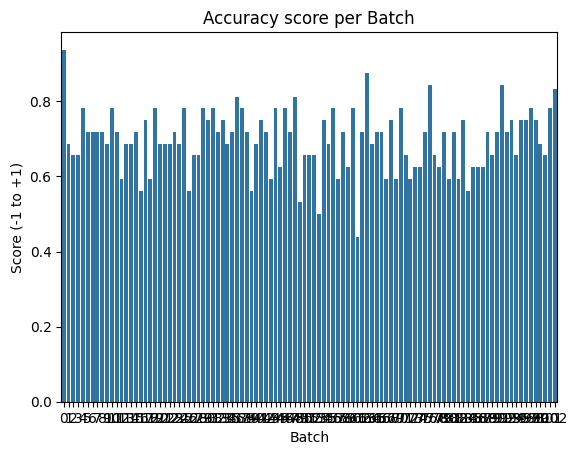

In [ ]:
# Create a barplot showing the accuracy score for each batch of test samples.
ax = sns.barplot(x=list(range(len(accuracy_set))), y=accuracy_set, ci=None)

plt.title('Accuracy score per Batch')
plt.ylabel('Score (-1 to +1)')
plt.xlabel('Batch')

plt.show()

We can see that in many batches accuracy score was close to 60-70%, but also in some batches result was even higher - close to 80%.




<ipython-input-70-4cb193381abc>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=['SVM w2v', 'SVM bert', 'Fine-tuned bert'], y=[accuracy, accuracy_1, accuracy_2], ci=None)


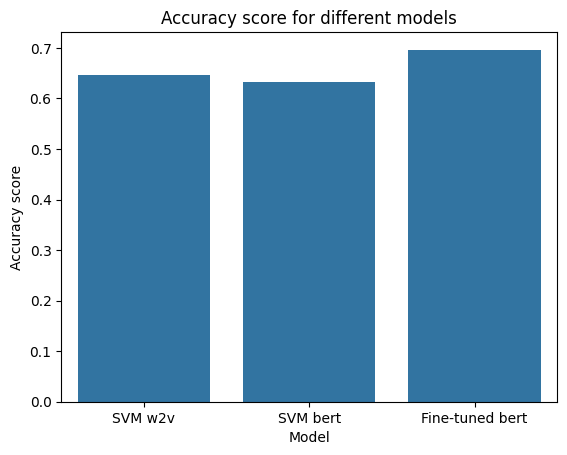

In [ ]:
# Create a barplot showing the accuracy score for each model
ax = sns.barplot(x=['SVM w2v', 'SVM bert', 'Fine-tuned bert'], y=[accuracy, accuracy_1, accuracy_2], ci=None)

plt.title('Accuracy score for different models')
plt.ylabel('Accuracy score')
plt.xlabel('Model')
plt.show()

As a result, the gighest accuracy score was obtained with fine-tuned pretrained BERT model. It is higher on more than 5% than results obtained with SVM models.

4.2 There are some ideas which may be helpful in improving the best model score:

1) The passages in our dataset were longer than avalible maximum length for BERT model. We can cut the longer texts off and only use the first 512 Tokens. But also we can split text in multiple subtexts, classify each of them and combine the results back together in order to get better result.

2) Self-Ensemble. It is proposed to use a self-ensemble method, in which the base models are the intermediate BERT models at different time steps within a single training process. The self-ensemble method with parameter averaging can improve BERT without significantly decreasing the training efficiency.

3)  Self-Distillation. Although the self-ensemble can improve the model performance, the training of the base model is the same as the vanilla fine-tuning strategy and cannot be affected by the ensemble model. So it is possible to use knowledge distillation to improve fine-tuning efficiency. At each time step in training, the current BERT model (called student model) is learned with two teachers: the gold labels and self-ensemble model (called teacher model). The teacher model is an average of student models at previous time steps. With the help of the teacher model, the student is more robustand accurate. Moreover, a better student model further leads to a better teacher model. A similar idea is also used in semisupervised learning, proposed self-distillation aims to optimize the student model without external data.

Mentioned ideas rely on results of current project and paper 'BERT Fine-Tuning via Self-Ensemble and Self-Distillation' (https://arxiv.org/pdf/2002.10345.pdf).